<a href="https://colab.research.google.com/github/carlosEcl06/informaticsMedImages/blob/main/colabGrupo2aval3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RIB0107 - Fundamentos de Informática em Imagens Médicas: Avaliação Parcial 3
## GRUPO 2: Carlos, Gabriel, Guilherme, Kathley, Raul, Victor, Vinícius e Vitor
### Construção e treinamento de um modelo de classificação baseado em rede neural convolucional para a diferenciação de fraturas vertebrais por compressão benignas e malignas

### 1. Importação de bibliotecas

In [1]:
# Se ainda não instalado, descomentar e rodar:
! pip install pynrrd

In [2]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nrrd
import string
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Importação da base de dados
Notas:
A base foi organizada pela Informata Biomédica (ex-aluna de nosso curso) Natália Santana Chiari Correia, como parte de sua pesquisa de doutorado no Programa de Pós-Graduação em Clínica Médica da FMRP, sob orientação dos Profs. Paulo e Marcello.

ATENÇÃO: Essa base é para uso exclusivo na disciplina e não pode ser compartilhada ou utilizada para outras finalidades sem autorização específica dos professores ou da sua organizadora.

A base contém:

- Os exames originais em formato DICOM anonimizados.
- Um arquivo .xlsx com a classe de cada paciente, o sexo, a idade e quais corpos vertebrais foram segmentados.
- Outras duas pastas além dos exames originais: uma com as imagens requantizadas para 256 níveis de tons de cinza no formato .nrrd e outra com os arquivos de segmentação no formato .seg.nrrd.

In [4]:
#caminhoCarlos="/content/drive/MyDrive/USP/Disciplinas/4º Período/RIB0107 - Fundamentos de Informática em Imagens Médicas/TrabalhoPrático3/dados"

# Adicione acima o seu caminho para a pasta dados, e antes de executar essa célula copie ele para o comando abaixo
! cp -r '/content/drive/MyDrive/USP/Disciplinas/4º Período/RIB0107 - Fundamentos de Informática em Imagens Médicas/TrabalhoPratico3/dados' '/content/'

Favor, verificar se a pasta dados apareceu na barra de arquivos do colab

In [5]:
! unzip '/content/dados/Cópia de 1-Original_Anon_Dicom-20220915T191018Z-001.zip'
! unzip '/content/dados/Cópia de 2-Rescaled_256_NRRD-20220915T191517Z-001.zip'
! unzip '/content/dados/Cópia de 3-Segmentation_NRRD-20220916T175039Z-001.zip'

Archive:  /content/dados/Cópia de 1-Original_Anon_Dicom-20220915T191018Z-001.zip
  inflating: 1-Original_Anon_Dicom/P18/I00008.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00012.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00010.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00007.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00004.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00006.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00009.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P30/I00003.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00003.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P1/I00011.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P30/I00008.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P30/I00011.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P1/I00010.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00011.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P1/I00002.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P1/I00005.dcm.dcm  
  inflating: 1-Original_An

As imagens da base agora se encontram distribuídas em três pastas presentes no diretório "content" do colab

In [6]:
# Leitura da tabela excel contendo informações dos pacientes
patientsTable = pd.read_excel('/content/dados/Cópia de Patients.xlsx')

### 3. Visualização inicial dos dados

In [7]:
patientsTable.head(5)

,Id,Age at the exam,Gender,Class,Segmented Vertebra
0,P1,67,F,benign,L1
1,P2,61,F,benign,L1/L3/L5
2,P3,65,M,benign,L1
3,P4,84,M,benign,L3
4,P5,78,F,benign,L1/L4


In [8]:
patientsTable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  91 non-null     object
 1   Age at the exam     91 non-null     int64 
 2   Gender              91 non-null     object
 3   Class               91 non-null     object
 4   Segmented Vertebra  91 non-null     object
dtypes: int64(1), object(4)
memory usage: 3.7+ KB


O DataFrame patientsTable possui 91 entradas e 5 colunas. As colunas "Id" e "Gender" contêm strings, enquanto as colunas "Age at the exam" e "Class" contêm números inteiros. Todas as colunas não têm valores nulos, o que significa que todas as entradas nas colunas possuem valores.

Para visualização inicial das imagens, foram utilizados os seguintes sites:

[Visualizador de imagens DICOM (extenção .dcm) gratuito na web](https://www.imaios.com/br/imaios-dicom-viewer)

[Conversor de arquivos "near raw" (.nrrd) para .dcm](https://www.onlineconverter.com/nrrd-to-dicom)

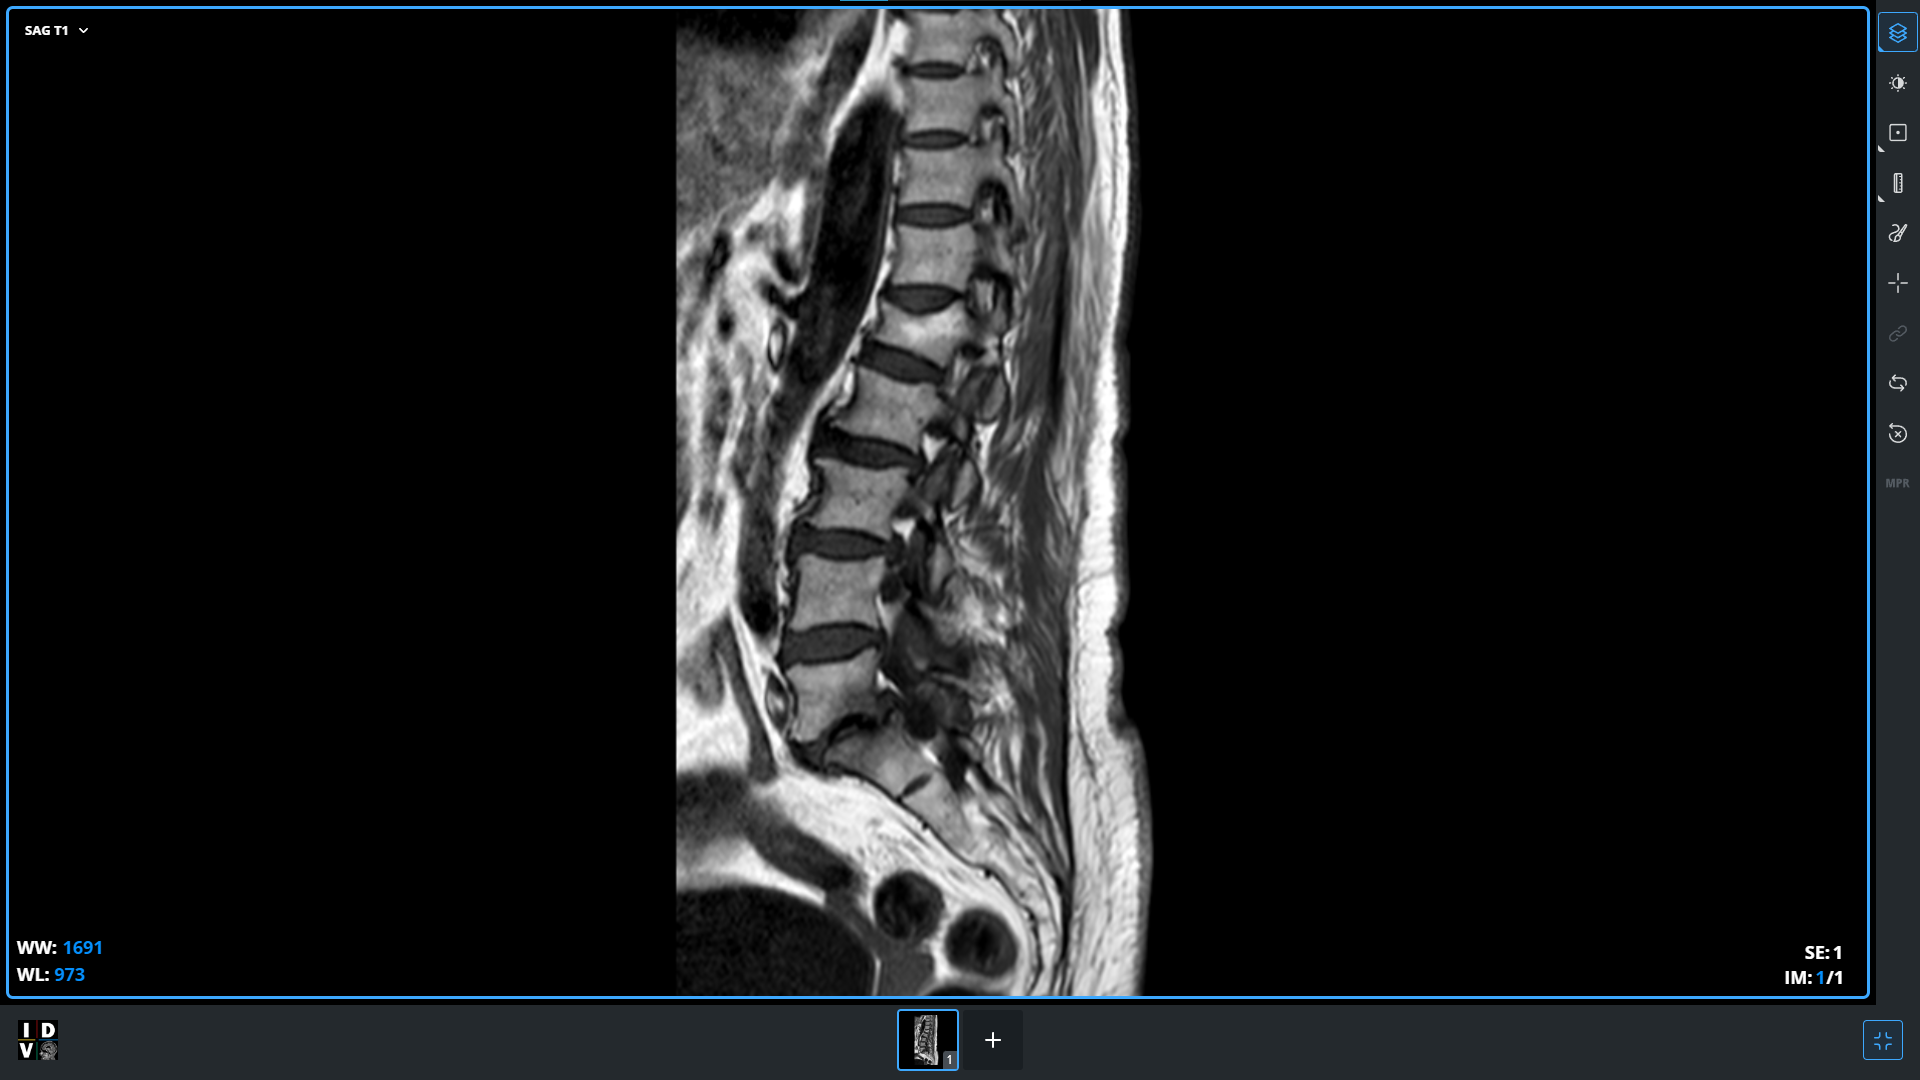
/content/1-Original_Anon_Dicom/P1/I00005.dcm.dcm aberta no visualizador web IMAIOS

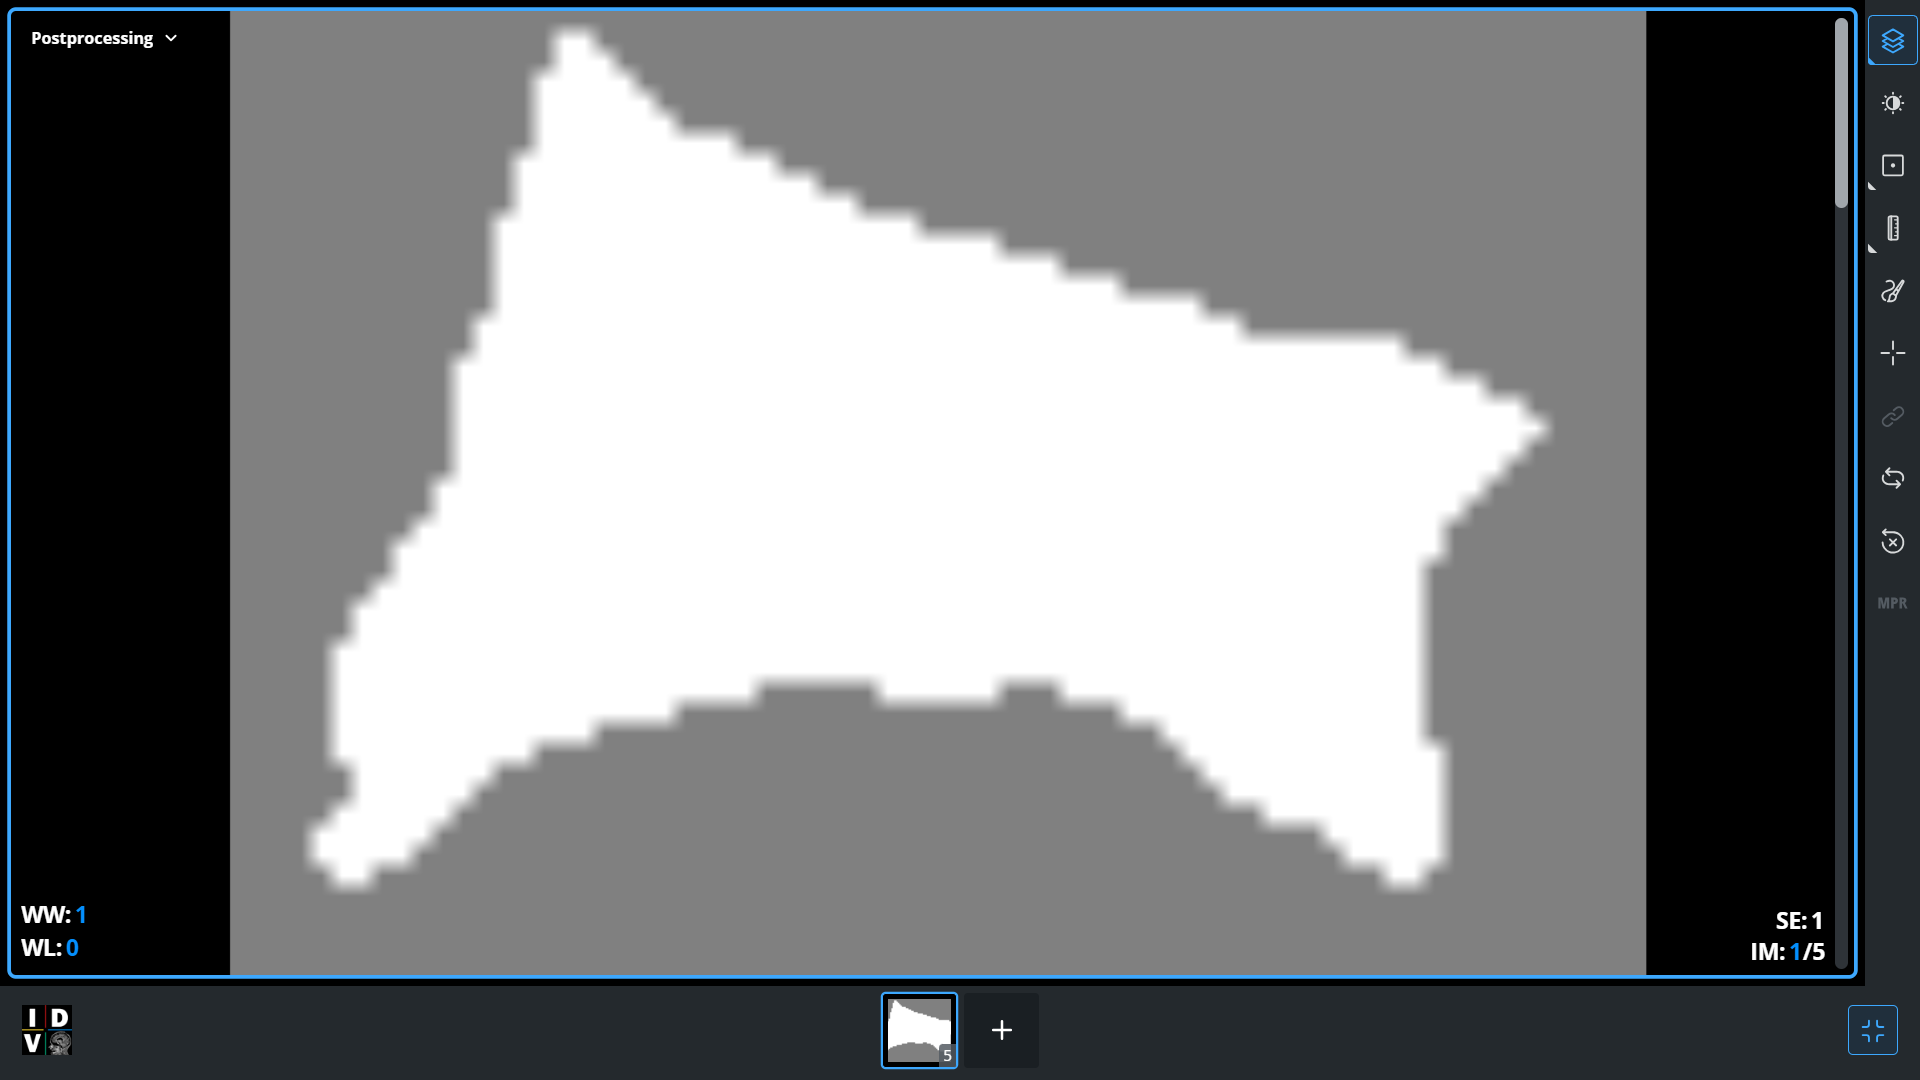
/content/3-Segmentation_NRRD/P1L1.seg.nrrd aberta no visualizador IMAIOS após conversão no Online Converter. É exibida a primeira de 5 fatias

Chaves do dicionário de máscaras: 'P1L1' = Paciente 1: Vértebra L1

Chave do dicionário de imagens: Apenas o paciente. ex: 'P1'

### 4. Pré-pocessamento das imagens. Utilização das máscaras.
#### 4.1 Preparo dos Dicionários

Máscaras

In [9]:
path_mask = '/content/3-Segmentation_NRRD/' # Caminho para as máscaras
os.chdir(path_mask)

In [10]:
masks = {}  # Cria um dicionário vazio chamado "masks"
header_mask = {}  # Cria um dicionário vazio chamado "header_mask"

In [11]:
seg_folder = '3-Segmentation_NRRD' # Nome do diretório contendo as segmentações
seg_sufix = '.seg.nrrd' # Extensão dos arquivos de segmentação

In [12]:
# Loop de leitura das segmentações
for file in os.listdir():
    if file.endswith(seg_sufix):
        file_path = path_mask + file
        # Encontre os índices das substrings 'seg_folder' e 'seg_sufix'
        segFolderIndex = file_path.index(seg_folder)
        segSufixIndex = file_path.index(seg_sufix)
        keyname = file_path[segFolderIndex + len(seg_folder):segSufixIndex]  # Criação da chave
        keyname = keyname.lstrip('/')  # Remove a barra da frente (se existir)
        # Leitura dos arquivos .nrrd
        masks[keyname], header_mask[keyname] = nrrd.read(file_path)

In [13]:
masks.keys()

dict_keys(['P51L5', 'P43L4', 'P8L3', 'P77L4', 'P59L4', 'P91L4', 'P7L1', 'P19L1', 'P22L2', 'P45L1', 'P62L4', 'P88L4', 'P6L3', 'P55L3', 'P27L4', 'P64L2', 'P48L3', 'P20L1', 'P55L2', 'P85L1', 'P11L2', 'P90L4', 'P17L3', 'P86L2', 'P23L2', 'P42L4', 'P45L3', 'P1L1', 'P80L5', 'P10L5', 'P79L4', 'P23L1', 'P8L4', 'P25L1', 'P21L2', 'P24L5', 'P14L3', 'P35L5', 'P33L1', 'P46L4', 'P12L2', 'P8L5', 'P53L1', 'P15L2', 'P72L1', 'P6L5', 'P84L3', 'P51L2', 'P18L4', 'P83L3', 'P13L2', 'P69L3', 'P26L4', 'P68L1', 'P70L3', 'P24L3', 'P10L4', 'P26L2', 'P49L1', 'P29L1', 'P15L4', 'P52L4', 'P56L1', 'P32L1', 'P16L2', 'P63L4', 'P42L1', 'P6L1', 'P87L5', 'P74L2', 'P61L1', 'P67L3', 'P78L2', 'P35L1', 'P42L5', 'P14L1', 'P10L3', 'P38L3', 'P26L1', 'P49L5', 'P42L2', 'P58L3', 'P28L4', 'P37L4', 'P38L4', 'P82L2', 'P81L1', 'P10L1', 'P50L5', 'P42L3', 'P3L1', 'P89L5', 'P32L4', 'P31L1', 'P34L1', 'P9L2', 'P66L4', 'P2L3', 'P47L3', 'P39L5', 'P24L2', 'P41L5', 'P38L5', 'P26L3', 'P60L2', 'P30L1', 'P35L4', 'P2L5', 'P4L3', 'P16L1', 'P56L2', 'P7

Segmentation mask key: P42L5


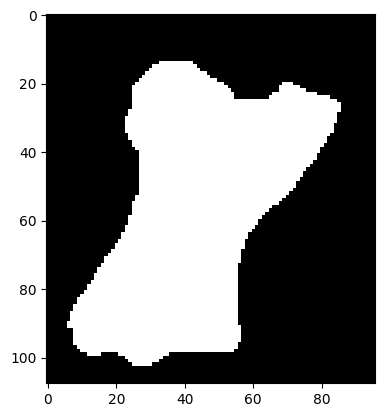

In [14]:
# Testando leitura - Exibindo imagem aleatória
rand_key = random.choice(list(masks.keys()))
plt.imshow(masks[rand_key][:,:,0], cmap='gray')
print('Segmentation mask key:',rand_key)

Imagens originais (versões rescaled)

In [15]:
path_image = '/content/2-Rescaled_256_NRRD/' # Caminho para as imagens
os.chdir(path_image)

In [16]:
images = {}  # Cria um dicionário vazio chamado "images"
header_image = {}  # Cria um dicionário vazio chamado "header_image"

In [18]:
img_folder = '2-Rescaled_256_NRRD' # Nome do diretório contendo as imagens
img_sufix = '.nrrd' # Extensão dos arquivos de imagem

In [19]:
# Loop de leitura das imagens
for file in os.listdir():
    if file.endswith(img_sufix):
        file_path = path_image + file
        # Encontre os índices das substrings 'img_folder' e 'img_sufix'
        imgFolderIndex = file_path.index(img_folder)
        imgSufixIndex = file_path.index(img_sufix)
        keyname = file_path[imgFolderIndex + len(img_folder):imgSufixIndex]  # Criação da chave
        keyname = keyname.lstrip('/')  # Remove a barra da frente (se existir)
        # Leitura dos arquivos .nrrd
        images[keyname], header_image[keyname] = nrrd.read(file_path)

In [20]:
images.keys()

dict_keys(['P55', 'P53', 'P52', 'P86', 'P66', 'P46', 'P62', 'P32', 'P76', 'P90', 'P64', 'P75', 'P20', 'P69', 'P48', 'P43', 'P84', 'P21', 'P58', 'P36', 'P24', 'P4', 'P41', 'P27', 'P42', 'P44', 'P83', 'P16', 'P3', 'P54', 'P37', 'P28', 'P29', 'P2', 'P57', 'P77', 'P68', 'P51', 'P13', 'P87', 'P82', 'P72', 'P35', 'P70', 'P6', 'P67', 'P78', 'P73', 'P17', 'P45', 'P56', 'P80', 'P10', 'P74', 'P33', 'P49', 'P19', 'P61', 'P59', 'P8', 'P89', 'P5', 'P14', 'P25', 'P12', 'P31', 'P38', 'P30', 'P23', 'P47', 'P71', 'P88', 'P50', 'P81', 'P15', 'P11', 'P60', 'P91', 'P9', 'P1', 'P40', 'P65', 'P85', 'P7', 'P26', 'P63', 'P18', 'P22', 'P34', 'P39', 'P79'])

Original image key: P49


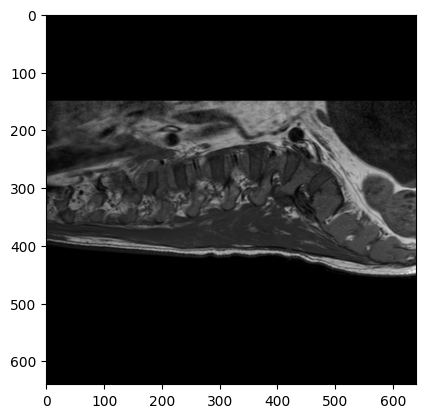

In [26]:
# Testando leitura - Exibindo imagem aleatória
rand_key = random.choice(list(images.keys()))
plt.imshow(images[rand_key][:,:,0], cmap='gray')
print('Original image key:',rand_key)